In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pws_library import get_data


In [24]:
class Backtest:
    
    def __init__(self, dependent_symbol, independent_symbol, halflife):
        self.dependent_symbol = dependent_symbol
        self.independent_symbol = independent_symbol
        self.halflife = halflife

        self.df = get_data([self.dependent_symbol, self.independent_symbol])
        if self.df.empty:
            print("no data pulled")
        else:
            self.calc_indicators()
            #self.generate_signals()
            self.match_signals()
            self.calc_profit()
            self.plot_chart()
        
    def calc_indicators(self):
        lookback = int(np.round(self.halflife))
        hedgeratios = np.array([])

        for i in range(self.df.shape[0]):
            if i < lookback-1:
                hedgeratios = np.append(hedgeratios, np.NaN)
            else:
                temporary = self.df.iloc[i-lookback+1:i+1]

                y = temporary[self.dependent_symbol].tolist()
                x = temporary[self.independent_symbol].tolist()

                x = sm.add_constant(x)

                results = sm.OLS(y, x).fit()
                hedgeratios = np.append(hedgeratios, results.params[1])


        self.df['hedgeratio'] = hedgeratios
        self.df['spread'] = self.df[self.dependent_symbol] - self.df[self.independent_symbol]*self.df['hedgeratio']
        self.df['zscore'] = (self.df['spread'] - self.df['spread'].rolling(lookback).mean()) / self.df['spread'].rolling(lookback).std()
        self.df.dropna(inplace=True)
    
#     def generate_signals(self):
#         entryZscore = 2.5
#         exitZscore = 0
        
#         conditions = [(self.df.zscore < -entryZscore), (self.df.zscore >= -exitZscore)]
#         choices = [1, 0]
#         self.df['num_long'] = np.select(conditions, choices, default=np.NaN)
        
#         conditions1 = [(self.df.zscore > entryZscore), (self.df.zscore <= exitZscore)]
#         choices1 = [-1, 0]
#         self.df['num_short'] = np.select(conditions1, choices1, default=np.NaN)
    
    
    def match_signals(self):
        # self.df['num_short'] = self.df['num_short'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
        # self.df['num_long'] = self.df['num_long'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
        # self.df['num_units'] = self.df['num_long'] + self.df['num_short']
        self.df['num_units'] = -self.df['zscore']
        
        self.df[f"{self.dependent_symbol}_pos"] = self.df['num_units'] * self.df[self.dependent_symbol]
        self.df[f"{self.independent_symbol}_pos"] = self.df['num_units'] * self.df[self.independent_symbol] * -self.df['hedgeratio']
        
        
    def calc_profit(self):
        dep_price = self.df[self.dependent_symbol]
        indep_price = self.df[self.independent_symbol]
        self.df[f'{self.dependent_symbol}_pnl'] = (dep_price-dep_price.shift())/dep_price.shift()*self.df[f'{self.dependent_symbol}_pos'].shift()
        self.df[f'{self.independent_symbol}_pnl'] = (indep_price-indep_price.shift())/indep_price.shift()*self.df[f'{self.independent_symbol}_pos'].shift()
        self.df['pnl'] = self.df[f'{self.independent_symbol}_pnl'] + self.df[f'{self.dependent_symbol}_pnl']
        
        self.ret = self.df['pnl'] / (np.abs(self.df[f'{self.dependent_symbol}_pos'].shift()) + np.abs(self.df[f'{self.independent_symbol}_pos'].shift()))
        self.ret = self.ret.fillna(0)
        
        self.returns_df = pd.DataFrame(self.ret, columns=['ret'])
        
        cum_ret = []
        for i in range(len(self.ret)):
            if i == 0:
                cum_ret.append(self.ret.iloc[i])
            else:
                cum_ret.append((self.ret.iloc[i] + 1) * (cum_ret[i-1]+1) - 1)
        

        self.returns_df['cum_ret'] = cum_ret
    
    def plot_chart(self):
        self.returns_df['cum_ret'].plot(figsize=(20,6))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


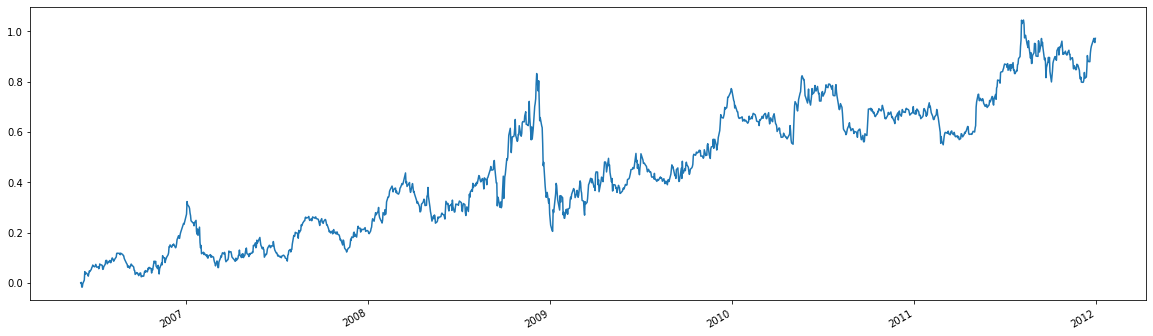

In [28]:
xlidis = Backtest(dependent_symbol='USO', independent_symbol='GLD', halflife=20)

<AxesSubplot:>

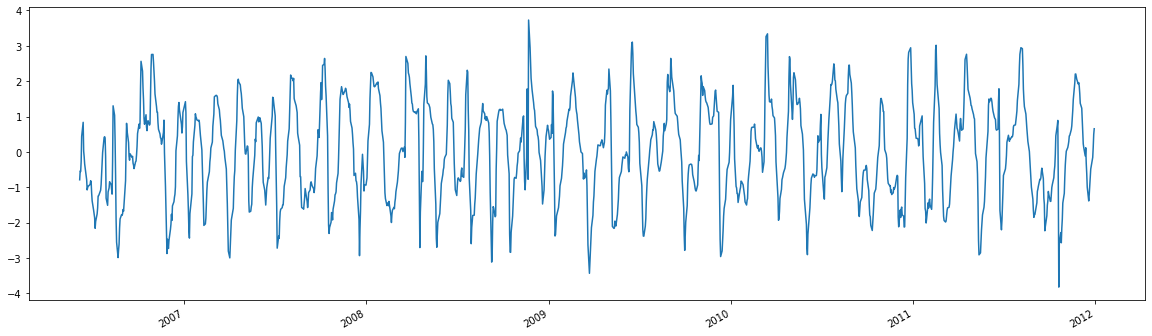

In [29]:
xlidis.df['zscore'].plot(figsize=(20,6))

<AxesSubplot:>

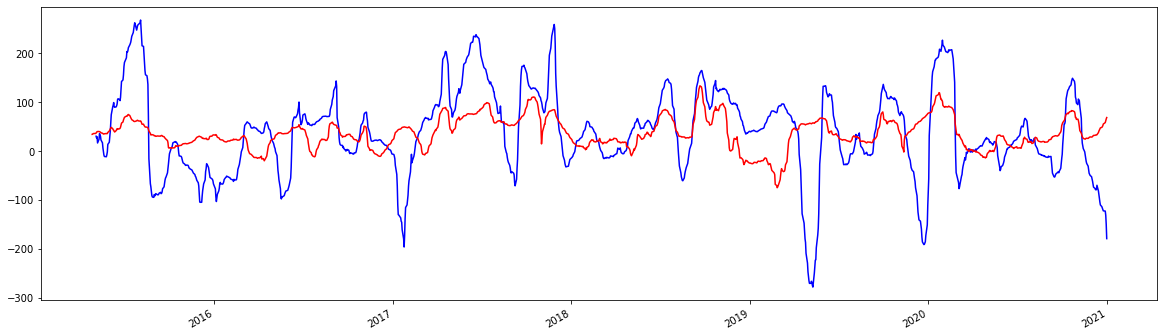

In [23]:
disxli.df['spread'].plot(figsize=(20,6), c='b')
xlidis.df['spread'].plot(figsize=(20,6), c='r')

<AxesSubplot:>

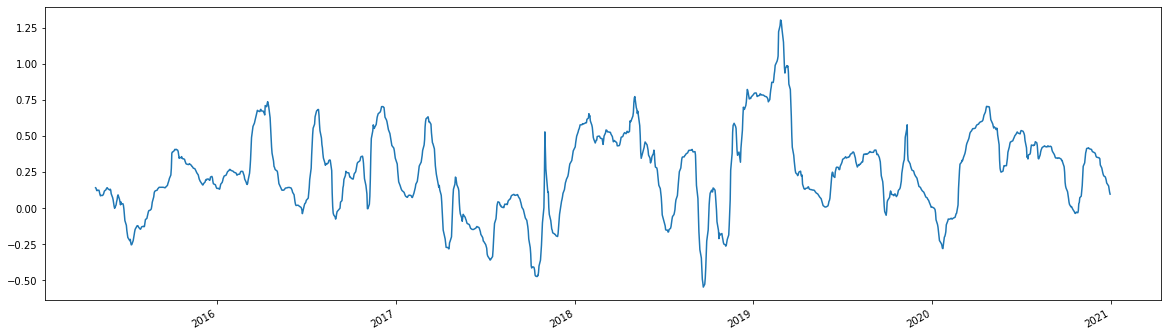